# Table of contents

1. [Introduction](#1)
2. [Dataset](#2)
3. [Part One - Analysis of Individual Waves](#3) <br>
    3.1 [Mean, dispersion (variance), skewness, and kurtosis (first four moments)](#3.1) <br>
    3.2 [Distribution of Free Surface Elevation](#3.2) <br>
    3.3 [Identify Up-crossing and Down-crossing individual waves and associated periods](#3.3) <br>
    3.4 [Significant wave height and significant wave period](#3.4) <br>
4. [Part Two - Spectral Analysis](#4) <br>
    4.1 [Autocorrelation function from time series](#4.1) <br>
    4.2 [Power Spectrum from FFT](#4.2) <br>
    4.3 [Noise Reduction with Daniell's, Bartlett and Welch’s methods](#4.3) <br>
    <!--  For some reason double nested sublists doesnt't seem to work    -->
<!--         1  [Daniell's Method](#4.3A) 
        2. [Bartlett's Method](#4.3B) 
        3. [Welch's Method](#4.3C) -->
    4.4 [Spectral Moments](#4.4) <br>
<!--         A. [First Four Spectral Moments](#4.4A) 
        B. [Spectral Bandwidth Coefficient](#4.4B)
        C. [Peak Period and Significant Height](#4.4C)
        D. [Significant Wave Height comparison with time domain analysis](#4.4C) <br> -->
    4.5 [Comparing obtained Power Spectrum with Theoretical Spectral Model](#4.5) <br>
5. [Webgraphy](#5)

# 1. Introduction <a name="1"></a>

The objective of this project is to perform statistical and spectral analysis of wave elevation time-series by analyzing a sample of the heave movements of a buoy deployed along the coast of Rio Grande do Sul, Brazil. This report describes procedures and equations used to arrive at results to the problems set out in the project specifications, always discussing them in the light of applied physical-mathematical modeling discussed in class.

# 2. Dataset <a name="2"></a>

The chosen sample contains data for the 31st of August 2009, measured at latitude -31,56667 and longitude -49.86667, located close to the city of Tavares, as shown in the figure below:

<br />
<img src="images/BuoyLatLong.png" alt="Latitude and Longitude of Buoy" width="600" />
<br />

The sample data is stored in a file with a .tsr extension named "W200908311900", with each line providing, for an instant in time (first column), corresponding data of "heave", "etaEW" and "etaNS" (second, third and fourth columns, respectively). The figure below contains a screenshot of the initial part of the sample:

<br />
<img src="images/SampleExample.png" alt="Sample Example" width="400" />
<br />

It appears from the data that the sampling interval is of 0.78 seconds, which corresponds to a frequency of 1.28 hertz. To facilitate data manipulation throughout this report, we convert data from the Sample.tsc file to a python array:

In [1]:
def getPythonSampleArray():
    '''Open a sample file with data in columns and returns a python array with the data'''
    SampleFile = open("W200908311900.tsr", "r")
    # We get all the lines of the Sample file, except the first three because they contain headers
    unformattedLines = SampleFile.readlines()[3:]
    
    def formatLine(line):
        '''Lines come as a string with the following format "   0.8\t  0.800\t   0.410000\t   0.470000\n". 
        This function convert this string into an array like [0.8, 0.8, 0.41, 0.47], where each number
        element in the array corresponds to a n time, heave, etaEW and etaNS, respectively'''
        return list(map(float, line.split()))

    return list(map(formatLine, unformattedLines))

pythonSampleArray = getPythonSampleArray()

Then we stratify the sample into arrays containing relevant data (times, heaves) to be used throughout the report:

In [2]:
def getTimesAndHeavesFromSample():
    '''Get data from sample and returns two arrays, with times and heaves'''
    # Loop through data inside the sample and get times and heaves only
    times, heaves = [], []
    for row in pythonSampleArray:
        time, heave = row[0], row[1]
        times.append(time)
        heaves.append(heave)
    return times, heaves

times, heaves = getTimesAndHeavesFromSample()

We then install the following packages: 

1. Numpy, to help us make certain array operations faster and easier;
2. MatPlotLib, to help us plot data; and
3. Scipy, to provide us algorithms for running data analysis; 

If any error indicating the need to install these packages occurs when running this notebook, uncomment the cell below and run it to install them.

In [3]:
# ! pip install numpy
# ! pip install matplotlib
# ! pip install scipy

We import the mentioned packages as officially advised and adopted by the community and import other python native packages. All of them are then available for use in the subsequent cells of this report.

In [4]:
# Community packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Native packages
import math

Because all of the relevant functions in Scipy are in submodules, we import their algorithms as needed in corresponding cells.

And we customize the properties and default styles of Matplotlib:

In [5]:
# Customizing matplotlib default styles

# We want to show a grid, as it makes data easier to read
# And we want to keep the figure titles bold as default
plt.rc("axes", grid=True, titleweight="bold") 

To get a visual sense of the behavior of the waves, we plot a graph of the heave against time for the entire and a subset of the time interval (the first 16 seconds):

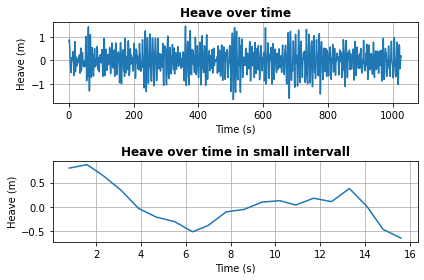

In [6]:
def plotHeavesVisualization():
    '''Plot two graphs with heaves over entire time interval and in a small interval'''
    # We create a figure made of 2 different plots
    fig, ax = plt.subplots(2)

    ax[0].plot(times, heaves) # We put all time values on x axis and heave values on y axis of the first plot
    ax[0].set_title("Heave over time")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Heave (m)")

    smallTimeInterval, smallHeaveInterval = times[0:20], heaves[0:20] # In the second plot, we analyse a smaller interval
    ax[1].plot(smallTimeInterval, smallHeaveInterval)
    ax[1].set_title("Heave over time in small intervall")
    ax[1].set_xlabel("Time (s)")
    ax[1].set_ylabel("Heave (m)")

    plt.tight_layout() # This ensures that plots do not overlap
    plt.show() # Command to effectively show plots

plotHeavesVisualization()

From where it can be seen that the heave movement seems to have a random character, which will be addressed throughout the report.

# 3. Part One - Analysis of Individual Waves <a name="3"></a>

## 3.1 Mean, dispersion (variance), skewness, and kurtosis (first four moments) <a name="3.1"></a>

In mathematics, the moments of a function are quantitative measures that contain information representative of a function or sample. By calculating these moments in our sample, it is possible to verify if the measured heaves data is compatible with what is theoretically expected. We consider the first moment to be the expected value, the second central moment the variance, the third standardized moment the skewness, and the fourth standardized moment the kurtosis. The formulas for each of these moments is presented below:


**Mean**
<br />
$x = \frac{1}{N} \sum_{i=1}^{N} x_i$

**Variance**
<br />
$σ^2 = \frac{1}{N-1} \sum_{i=1}^{N} (x_i - x)^2$

**Skewness**
<br />
$S = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^3}{σ^3}$

**Kurtosis**
<br />
$K = \frac{1}{N} \sum_{i=1}^{N} \frac {(x_i - x)^4}{σ^4}$

Using these definitions, we can calculate the four probabilistic moments for the heaves (time moments are not relevant to our analysis):

In [7]:
from scipy.stats import skew, kurtosis

# Using numpy and scipy to calculate relevant probabilistic moments for heave
heaveMean = np.mean(heaves)
heaveVariance = np.var(heaves)
heaveSkewness = skew(heaves)
heaveKurtosis = kurtosis(heaves, fisher=False) # fisher=False means it is not the extreme kurtosis

# We also make the heave standard deviation avaliable throughout the report
heaveStandardDeviation = np.sqrt(heaveVariance)

And present them in a table:

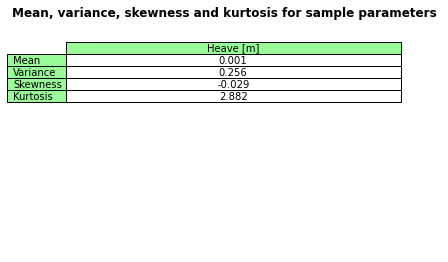

In [8]:
def plotHeaveProbabilisticMomentsTable():
    '''Plots a table with the heaves first four probabilist moments'''
    # So that we can loop easily through moments
    heaveMoments = [heaveMean, heaveVariance, heaveSkewness, heaveKurtosis]
    
    rowLabels = ["Mean", "Variance", "Skewness", "Kurtosis"] # Labels in row headers
    plt.table(
        # Data
        colLabels=[f"Heave [m]"], # Labels in column headers
        rowLabels=rowLabels, 
        cellText=[[round(moment, 3)] for moment in heaveMoments], # We round the moments to be more presentable
        # Styles
        rowColours=["palegreen"] * len(rowLabels), # Color of row headers
        colColours=["palegreen"], # Color of column headers
        cellLoc="center", # Position of data in table cell
        loc="upper left") # Position of table in Jupyther cell    
    
    plt.axis("off") # As we don't want to show x-axis and y-axis in a table
    plt.title("Mean, variance, skewness and kurtosis for sample parameters \n") # \n means we jump a line
    plt.show() 
    
plotHeaveProbabilisticMomentsTable()

From the table, we can see that the mean and skewness values are sufficiently close to zero so that 
subsequent assumptions in the report for obtaining analytical short-terms probabilistic distributions of the wave characteristics are met. Knowing that the kurtosis of the normal distribution (which will be used later) is 3, it appears that the obtained value (2.882) is also compatible with what is expected, validating the sample for subsequent analysis.

## 3.2 Distribution of Free Surface Elevation <a name="3.2"></a>
(in comparison with Gaussian and Longuet-Higgins distributions)

Here we treat the generation of waves as a random process, whose randomness follows from the nature of the generating forces and is a consequence of various instabilities in the wave evolution process. If we assume that the wave is a composition of denumerably many independent harmonic components, then by the central limit theorem the distribution of free-surface elevation (and by extension the heave movement of analyzed buoy) becomes Gaussian. In the case of weak nonlinear interactions, a certain deviation from the Gaussian distribution may appear, as shown theoretically by Longuet-Higgins (1963). The nonlinearity is then introduced employing the third- and fourth-order normalized central moments, μ3 (skewness) and μ4 (extreme kurtosis), with the following coefficients:

$λ_3 = \frac {μ_3}{σ_n^3}$ <br />
$λ_4 = \frac {μ_4}{σ_n^4} -3$

Where $σ_n$ is the standard deviation, $λ_3$ is the coefficient of skewness, a measure of the increasing vertical asymmetry in the wave profile due to second-order nonlinear interactions, and $λ_3$ the coefficient of kurtosis, which reflects the total increase of the crest-to-trough wave height due to third-order nonlinear interactions. Considering that the wave profiles have Gaussian distribution with unit variance ($σ_n = 1$, a reasonable assumption for our the low standard deviation of our sample), we get that $λ_3 = μ_3 =$ skewness, $λ_4 = μ_4 - 3 =$ extreme kurtosis. Then the Longuet-Higgins distributions get the follow equation:


$f(x) = \frac {1}{σ \sqrt{2\pi}} e^{\frac {-x^2}{2}} [1 + \frac{λ_3 H_3(x)}{3!} + \frac{λ_4 H_4(x)}{4!} + \frac{10 λ_3^2 H_6(x)}{6!} +  ...]$

Where, for the heave sample, σ is the standard deviation and $x = \frac {h}{σ}$, $h$ being the heave.

For $H_n$ being the Hermite polynomials, given, negleting terms with high denominators, by: <br />
$H_3 = x^3 - 3x$ <br />
$H_4 = x^4 - 6x^2 + 3$ <br />
$H_6 = x^6 - 15x^4 + 45x^3 - 15$ <br />

To simplify the application of this formula in program, we can divide it into two terms: <br />
$NormalDistributionFactor(x) = \frac {1}{σ \sqrt{2\pi}} e^{\frac {-x^2}{2}}$ <br />
$MultiplyingFactor(x) = [1 + \frac{λ_3 H_3(x)}{3!} + \frac{λ_4 H_4(x)}{4!} + \frac{10 λ_3^2 H_6(x)}{6!}]$

Then: <br />
$f(x) = NormalDistributionFactor(x).MultiplyingFactor(x)$

We can calculate the value for the Longuet-Higgins distribution as:

In [9]:
from scipy.stats import norm

def longuetHigginsDensityDist(heaves, mean, standardDeviation, skewness, extremeKurtosis):
    '''Receives a list of heaves and the corresponding four probabilistc moments 
    (with the extreme kurtosis, which is kurtosis - 3). Returns a list of densities
    for the probabilistic distribution function'''
    def x(heave): return heave/standardDeviation
    def H3(x): return x**3 - 3*x 
    def H4(x): return x**4 - 6*(x**2) + 3
    def H6(x): return x**6 - 15*(x**4) + 45*(x**2) - 15
    
    def normalDistFactor(heave):
        '''Receives a heave and returns the normal distribution pdf
        value for that heave with mean and standard deviation as passed
        for the sample of heaves'''
        # More information about norm.pdf: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
        return norm.pdf(heave, loc=mean, scale=standardDeviation)
    
    lambda3, lambda4 = skewness, extremeKurtosis
    def multiplyingFactor(heave):
        '''Receives a heave and returns the multipying factor to the
        normal distribution value of the Longuet-Higgins distribution, 
        considering mean heave being zero'''
        # We consider the multiplying factor to be 1 + second term + third term + fourth term
        second = (lambda3/math.factorial(3))*H3(x(heave))
        third = (lambda4/math.factorial(4))*H4(x(heave))
        fourth = ((lambda3**2)/math.factorial(6))*10*H6(x(heave))
        return 1 + second + third + fourth
    
    def f(heave):
        return normalDistFactor(heave)*multiplyingFactor(heave)
    
    densities = [f(heave) for heave in heaves]
    return densities

We use empirical data of the heaves to construct a histogram and compare the results with Gaussian and Longuet-Higgins distributions (with the probabilistic moments of the data as inputs):

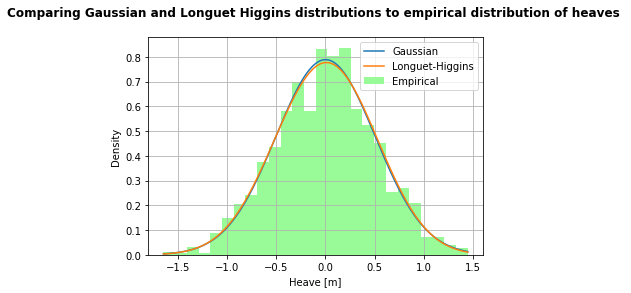

In [10]:
def compareDistributionsWithEmpiricalData():
    '''Using empirical heaves data (and corresponding probabilistic moments), plots a 
    graph comparing empirical with Gaussian and Longuet-Higgins distributions'''
    # Determining best bin fit for data. For more details, see:
    # https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
    # PS: "_" is commonly used in python as a placeholder for variables that are not going to be used,
    # but must be assigned to unpack other variables
    _, bins = np.histogram(heaves, bins="auto", density=True)

    # We are going to compare empirical obtained heaves with Gaussian and
    # Longuet-Higgins distributions (which are continuous functions). To make
    # them look continuous in plot, we generate a larger number of heave values
    # within the bin interval. 
    # This should be equivalent to np.linspace(min(heaves), max(heaves), num=1000)
    largeNumberOfHeaves = np.linspace(min(bins), max(bins), num=1000) 

    # Calculating densities of Gaussian and Longuet-Higgins distributions
    gaussianDensities = norm.pdf(largeNumberOfHeaves, loc=heaveMean, scale=heaveStandardDeviation)
    longuetHigginsDensities = longuetHigginsDensityDist(
        heaves=largeNumberOfHeaves, 
        mean=heaveMean,
        standardDeviation=heaveStandardDeviation, 
        skewness=heaveSkewness,
        extremeKurtosis=heaveKurtosis-3) # Extreme kurtosis is just kurtosis - 3

    # Ploting Gaussian, Longuet and empirical data in the same figure
    plt.plot(largeNumberOfHeaves, gaussianDensities, label="Gaussian")
    plt.plot(largeNumberOfHeaves, longuetHigginsDensities, label="Longuet-Higgins")
    plt.hist(heaves, bins=bins, density=True, color="palegreen", label="Empirical") 
    
    plt.legend(loc="best") # Optimal position for labels
    plt.title("Comparing Gaussian and Longuet Higgins distributions to empirical distribution of heaves \n") 
    plt.xlabel("Heave [m]")
    plt.ylabel("Density")
    plt.show()
    
compareDistributionsWithEmpiricalData()

From the graph, it is possible to see that the distributions fit the data well and are quite similar - indicating that the effect of weak nonlinear wave interactions is negligible. This is somewhat expected, as the principal contribution to the asymmetry of the Longuet-Higgins distribution and the observed good fit with the heave data is the coefficient of skewness, which is quite low in our analysis.

## 3.3 Identify Up-crossing and Down-crossing individual waves and associated periods <a name="3.3"></a>
Representing wave heights in a histogram and comparing them with the Rayleigh distribution.

The standard method of determining the short-term statistics of a wave record is through the zero-crossing analysis. Either the so-called zero-up crossing method or the zero-downcrossing method may be used; the obtained statistics should be the same for both methods when using a sufficiently long sample. 

For the zero-upcrossing method, the mean water level is first determined. The wave record is marked each time the water surface crosses the mean level in an upward direction. Individual waves are then identified between the upcrossings and the individual wave height, $H_i$, and wave period, $T_i$, are determined, where i is an index counter to identify each wave. An equivalent procedure is used to determine waves with the zero-downcrossing method, with the waves marked each time the water surface crosses the mean level in a downward direction.

We can mark the waves with the following procedure:
1. Detrend (a technique to remove unwanted trends from time-series data) heaves by subtracting each
   heave value by the mean heave;
2. Convert each obtained value to a signal (if the value is positive, it is converted to +1. If is
   negative, -1. And if is 0, it continues to be 0);
3. For each signal, get the difference between the current signal and the last signal.
    1. If the difference is 2, it means the current signal (and consequently heave) is **positive**
    and the last signal was **negative** (+1 - (-1) = 2). So we are dealing with an **up-crossing wave**;
    2. If the difference is -2, it means the current signal (and consequently heave) is **negative**
    and the last signal was **positive** (-1 - (+1) = -2). So we are dealing with a **down-crossing wave**;
4. Mark the indexes for each occurrence of a zero-crossing wave in each case (up or down) and then use those 
   indexes to identify waves and extract relevant wave statistics.

Because we are going to use detrended heave data in part two as well, we make it available throughout the report, ensuring that the applied detrending technique (in this case, subtracting each heave value by the mean) is the same in both parts:

In [11]:
detrendedHeaves = np.asarray(heaves) - np.mean(heaves)

In [12]:
def getHeavesCrossingIndexes():
    '''Assuming heave data is already detrended (step 1), apply the algorithm of: 
    2) Convert detrended heave values to signals
    3) Compute the difference between current and last obtained signals
    4) Find and return up and down-crossing indexes'''

    # 2: We convert detrended heaves into signals, ie, for each detrended heave,
    # it returns -1 if heave < 0, 0 if heave == 0, 1 if heave > 0 
    # https://numpy.org/doc/stable/reference/generated/numpy.sign.html?highlight=sign#numpy.sign
    signals = np.sign(detrendedHeaves)

    # 3: We compute the difference between current and last signals, that is, for i being an
    # index, diff[i] = signal[i+1] - signal[i]
    # https://numpy.org/doc/stable/reference/generated/numpy.diff.html
    diffs = np.diff(signals)

    # 3A and 3B: We then find the indexes of values in diffs. If the difference between two
    # consecutive signals were equal to 2, it means it is an up crossing, and if it is equal to
    # - 2, it is a down crossing.
    # https://numpy.org/doc/stable/reference/generated/numpy.where.html?highlight=where#numpy.where
    upCrossingIndexes = np.where(diffs == 2)[0]
    downCrossingIndexes = np.where(diffs == -2)[0]
    return upCrossingIndexes, downCrossingIndexes

upCrossingIndexes, downCrossingIndexes = getHeavesCrossingIndexes()

def getWaves(crossingIndexes):
    '''Receives the indexes of a zero-crossing analysis and
    returns a list of waves, each wave containing its number 
    (from the order it appears), height, period and order 
    (rank of height, ie, the biggest wave will be 1, the second
    biggest 2, and so on)'''
    waves, lastIndex = [], crossingIndexes[0]
    for n, currentIndex in enumerate(crossingIndexes[1:]):
        waveHeaves = heaves[lastIndex:currentIndex]
        wave = { "number": n + 1, 
                 "height": max(waveHeaves) + np.abs(min(waveHeaves)), 
                 "period": times[currentIndex] - times[lastIndex] }
        waves.append(wave)
        lastIndex = currentIndex
    
    def getOrders():
        '''Easyest way to rank an array. See:
        https://codereview.stackexchange.com/questions/65031/creating-a-list-containing-the-rank-of-the-elements-in-the-original-list
        TODO: ideally this should be refactored to a more readable code, 
        we're just sorting the wave list according to highest wave height'''
        heights = [wave["height"] for wave in waves]
        orders = [0] * len(heights)    
        for i, x in enumerate(sorted(range(len(heights)), key=lambda y: heights[y], reverse=True)):
            orders[x] = i + 1
        return orders
    
    # Appending orders to each wave
    orders = getOrders()
    for i, wave in enumerate(waves):
        wave["order"] = orders[i]
    return waves

upCrossingWaves = getWaves(upCrossingIndexes)
downCrossingWaves = getWaves(downCrossingIndexes)

In [13]:
def plotWavesTable(waves, direction):
    '''Receives a list of waves and the corresponding crossing analysis direction
    and plots a table with corresponding wave numbers, heights, periods and orders'''
    colLabels = ["Wave Number", "Wave Height H(m)", "Wave Period T(s)", "Order Number"]
    table = plt.table(
        colLabels=colLabels,
        cellText=[[round(val, 3) for val in wave.values()] for wave in waves],
        colColours=["palegreen"] * len(colLabels), 
        cellLoc="center",  
        loc="center")   
    table.auto_set_font_size(False) # Making sure we can mannually set the fonsize
    table.scale(1.6, 1.1) # Make the table bigger horizontally and vertically
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title(f"Wave Numbers, Heights, Periods and Orders from a zero-{direction}crossing analysis \n", fontsize=14) 
    plt.show()

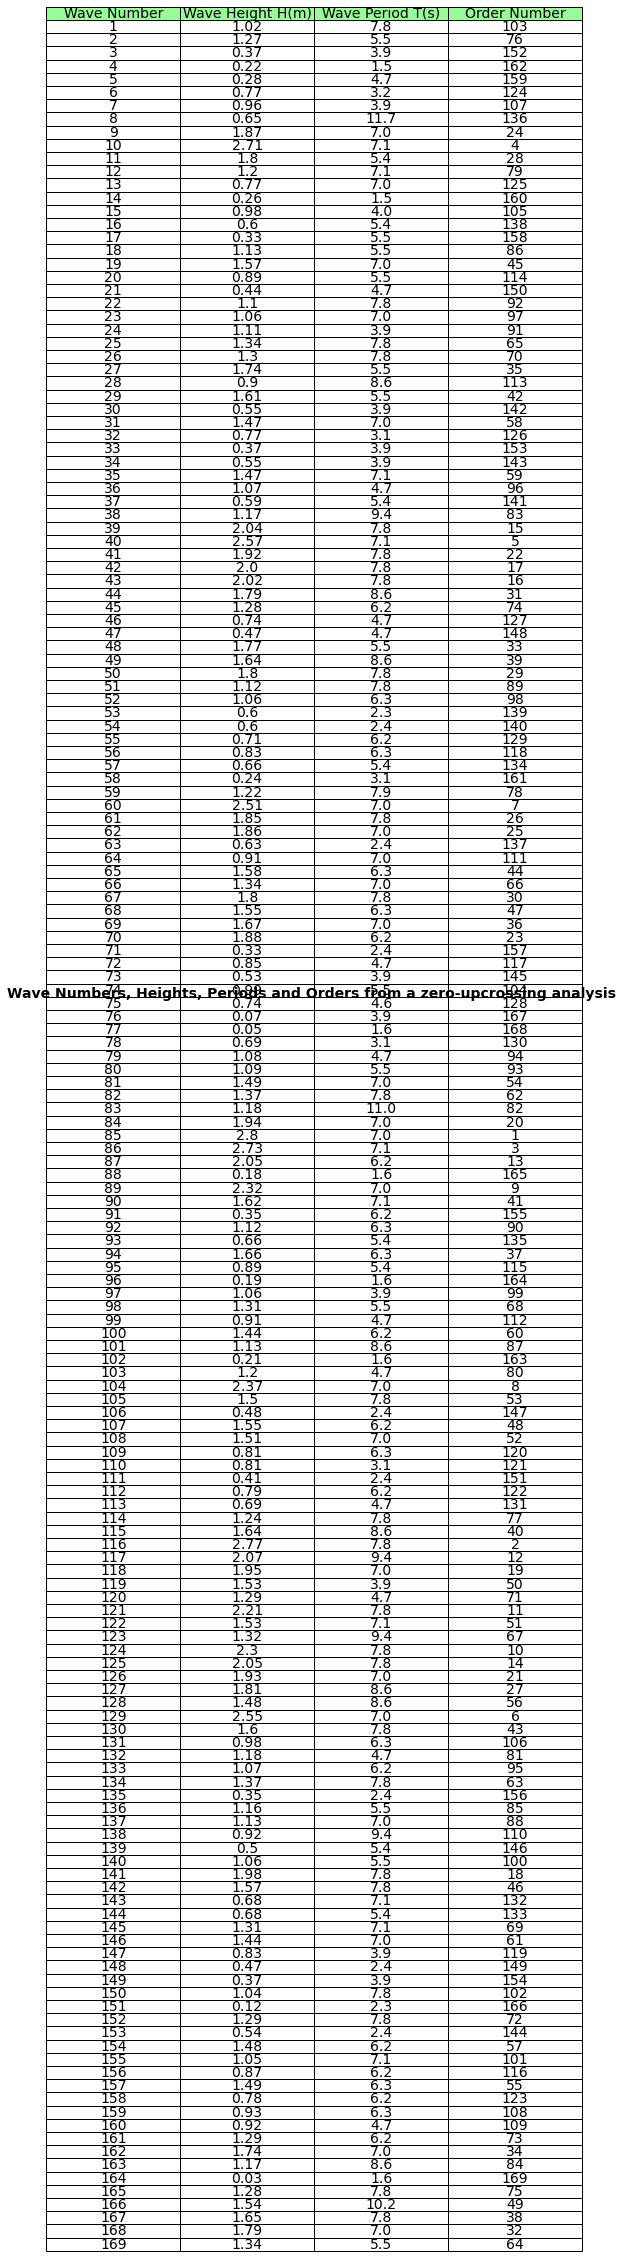

In [14]:
plotWavesTable(upCrossingWaves, direction="up")

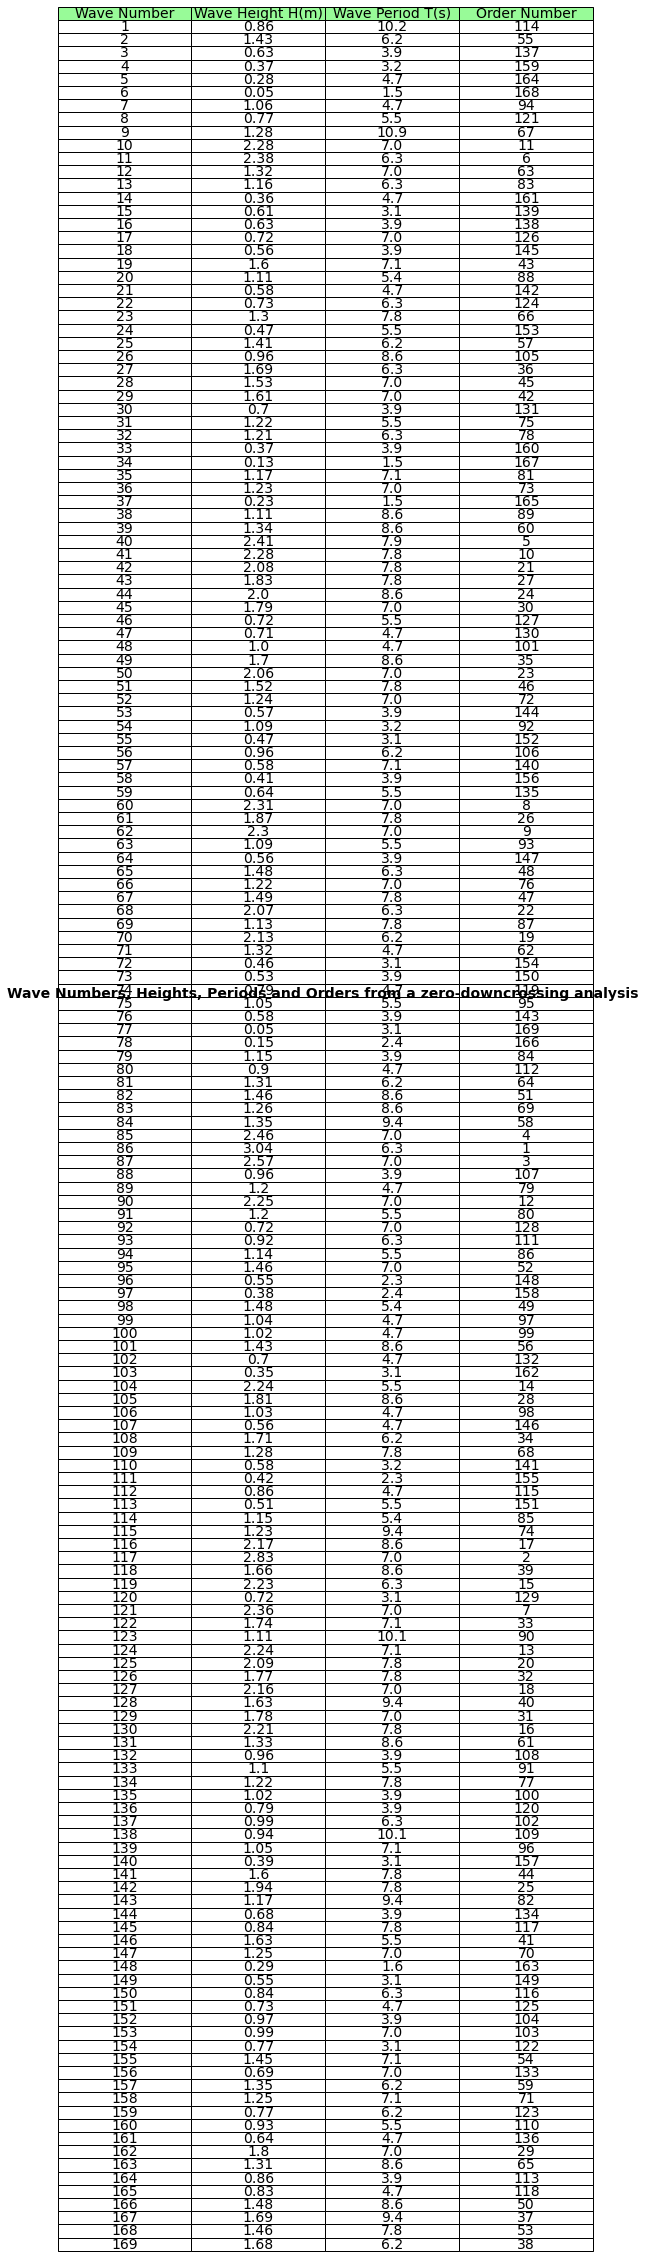

In [15]:
plotWavesTable(downCrossingWaves, direction="down")

In [16]:
def getWavesStatistics(waves):
    '''Receives a list of waves and returns its mean height, maximum height,
    the period corresponding to the maximum height wave and the number of waves'''
    heights, periods = [], []
    for wave in waves:
        heights.append(wave["height"])
        periods.append(wave["period"])
    
    meanHeight = np.mean(heights)
    maxHeight = np.amax(heights)
    maxHeightIndex = np.where(heights == maxHeight)[0][0]
    maxHeightPeriod = periods[maxHeightIndex]
    numberOfWaves = len(waves)
    
    return { "meanHeight": round(meanHeight, 6), "maxHeight": round(maxHeight, 6),
             "maxHeightPeriod": round(maxHeightPeriod, 6), "numberOfWaves": numberOfWaves }
        
# We get the statistics for both up and down-crossing waves
upCrossingStats = getWavesStatistics(upCrossingWaves)
downCrossingStats = getWavesStatistics(downCrossingWaves)

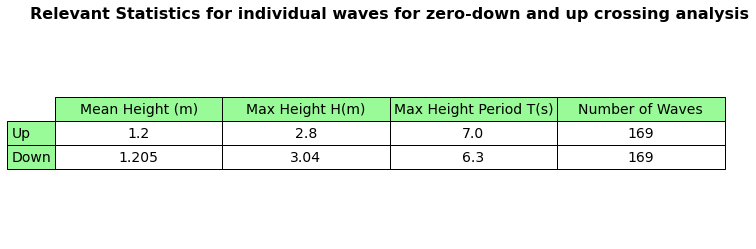

In [17]:
def plotWavesStatsTable(upCrossingStats, downCrossingStats):
    '''Receives statistics from up and downcrossing waves and
    plots a table showing these statistics'''
    colLabels = ["Mean Height (m)", "Max Height H(m)", "Max Height Period T(s)", "Number of Waves"]
    rowLabels = ["Up", "Down"]
    table = plt.table(
        colLabels=colLabels,
        rowLabels=rowLabels,
        cellText=[[round(val, 3) for val in stats.values()] for stats in [upCrossingStats, downCrossingStats]],
        colColours=["palegreen"] * len(colLabels),
        rowColours=["palegreen"] * len(rowLabels), 
        cellLoc="center",  
        loc="center")         
    table.auto_set_font_size(False) 
    table.scale(2, 2) 
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title("Relevant Statistics for individual waves for zero-down and up crossing analysis", fontsize=16) 
    plt.show()
    
plotWavesStatsTable(upCrossingStats, downCrossingStats)

From the table above, we can see that we get the same number of waves for both methods, and the maximum wave height and the wave period associated with the wave with maximum height is the same up to 3 digits. Although the mean height obtained by the two methods are different, the percentual discrepancy between the values obtained is approximately 3.1%, which is acceptable since, as mentioned before, the statistics obtained by the two methods is not necessarily equal, but simply must be more and more similar as the sample size increases.

We also know that, theoretically, random wave heights follow the Rayleigh Probability Distribution, which can be mathematically expressed in several different forms. Using the mean heave $H_{mean}$ as reference and $H$ as a heave, this distribution may be expressed as:

$f(H) = \frac{\pi H}{2 H_{mean}^2} e^\frac{-\pi H^2}{4 H_{mean}^2}$

Which can be obtained as:

In [18]:
def rayleighDensityDist(heights):
    '''Receives a list of wave heights and returns a list of densities
    for the rayleigh probabilistic distribution function'''
    meanHeightSquared = np.mean(heights)**2
    def multiplyingFactor(H):
        return (np.pi*H) / (2*meanHeightSquared)
    
    def exponentialFactor(H):
        numerator = -np.pi*(H**2)
        denominator = 4*meanHeightSquared
        return np.exp(numerator/denominator)
    
    def f(H):
        return multiplyingFactor(H)*exponentialFactor(H)
    
    densities = [f(H) for H in heights]
    return densities

As we are going to check if the Rayleigh distribution matches the histogram of wave heights obtained by both zero down and up-crossing methods, we create a function to make a plot with the comparison having the list of heights as an input:

In [19]:
def plotRayleighComparison(waveHeights, direction):
    '''Receives a list of wave heights and a direction (up or down)
    and plots an histogram of wave heights with a corresponding
    expected Rayleigh distribution'''
    # Determining best bin fit for wave heights in histogram
    _, bins = np.histogram(waveHeights, bins="auto", density=True)
    
    # We are going to compare empirical obtained wave heights with the expected
    # Rayleigh distribution (which is a continuous function). To make it look
    # continuous in plot, we generate a larger number of wave heights values
    # within the bin interval. 
    # This should be equivalent to np.linspace(min(waveHeights), max(waveHeights), num=1000)
    largeNumberOfWavesHeights = np.linspace(min(bins), max(bins), num=1000)
    rayleighDensities = rayleighDensityDist(largeNumberOfWavesHeights) 
    
    # Ploting Rayleigh distribution and empirical data in the same figure
    plt.plot(largeNumberOfWavesHeights, rayleighDensities, label="Rayleigh")
    plt.hist(waveHeights, bins=bins, density=True, color="palegreen", label="Empirical")
    plt.legend(loc="best")
    plt.title(f'''Comparing Rayleigh distribution to empirical distribution of Wave Heights
        for zero-{direction} crossing analysis \n''')
    plt.xlabel("Wave Height H(m)")
    plt.ylabel("Density")
    plt.show()

So we make the comparison for wave heights obtained with the zero up-crossing method:

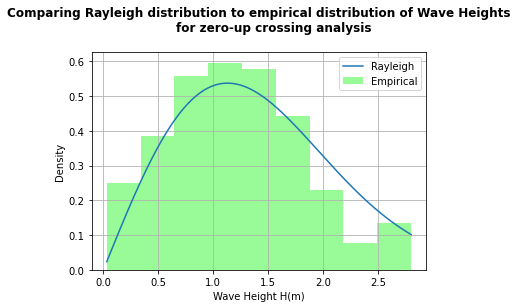

In [20]:
upCrossingWaveHeights = [wave["height"] for wave in upCrossingWaves]
plotRayleighComparison(upCrossingWaveHeights, direction="up")

And for wave heights obtained with the zero down-crossing method we have:

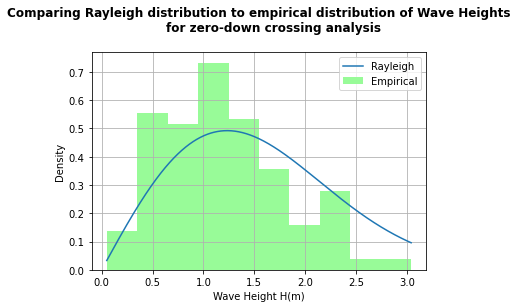

In [21]:
downCrossingWaveHeights = [wave["height"] for wave in downCrossingWaves]
plotRayleighComparison(downCrossingWaveHeights, direction="down")

Analyzing both graphs, it appears that the Rayleigh distribution represents the wave height distribution accurately enough for both methods.

## 3.4 Significant wave height and significant wave period <a name="3.5"></a>
(and comparison of significant wave height to mean wave height and maximum wave height)

The most widely used statistical wave height for a short term wave record is the so-called significant height, denoted as $H_s$. The significant wave height is defined as the mean of the largest one-third of the waves in the wave record. Because we already did rank ordered wave heights, we can easily calculate the significant wave height by considering the average of the top one-third (${N/3}$) with the formulas below: 

**Significant Wave Height**
<br />
$H_s = \frac{1}{N/3} \sum_{i=1}^{N/3} H_i$

Similarly, for the significant period we have:


**Significant Period**
<br />
$T_s = \frac{1}{N/3} \sum_{i=1}^{N/3} T_i$

By calculating those values, we get:

In [22]:
def getWavesSignificantStatistics(waves, direction):
    '''Receives a list of waves and a direction (up or down) and
    returns an array containing the significant height and significant
    period, respectively'''
    topThird =int(round(len(waves)/3))
    sHeightSum, sPeriodSum = 0, 0
    for wave in waves:
        order = wave["order"]
        if order <= topThird:
            sHeightSum += wave["height"]
            sPeriodSum += wave["period"]
    
    significantHeight = sHeightSum / topThird
    significantPeriod = sPeriodSum / topThird
    
    print(f"Significant Height for zero-{direction} crossing method: {significantHeight}")
    print(f"Significant Period for zero-{direction} crossing method: {significantPeriod} \n")
    return { "significantHeight": significantHeight, "significantPeriod": significantPeriod }

upCrossingSignificantStats = getWavesSignificantStatistics(upCrossingWaves, direction="up")
downCrossingSignificantStats = getWavesSignificantStatistics(downCrossingWaves, direction="down")

Significant Height for zero-up crossing method: 1.8976785714285709
Significant Period for zero-up crossing method: 7.223214285714287 

Significant Height for zero-down crossing method: 1.9169642857142848
Significant Period for zero-down crossing method: 7.29464285714286 



Then we can compare significant height with average and maximum heights:

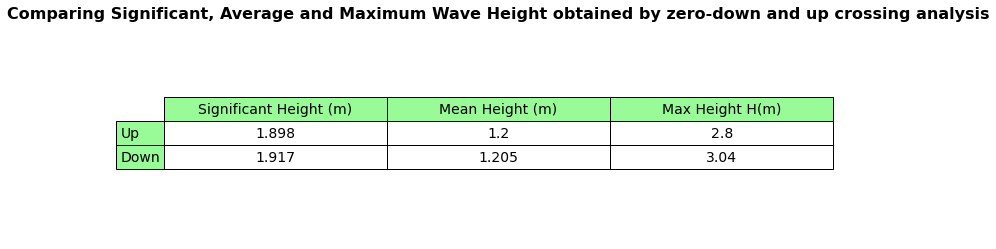

In [23]:
# Unifing up-crossing heights
upCrossingHeights = [upCrossingSignificantStats["significantHeight"],
                          upCrossingStats["meanHeight"],
                          upCrossingStats["maxHeight"]]

# Unifing down-crossing heights
downCrossingHeights = [downCrossingSignificantStats["significantHeight"],
                          downCrossingStats["meanHeight"],
                          downCrossingStats["maxHeight"]]


def plotHeightsComparison(upHeights, downHeights):
    '''Receives up and downcrossing heights and plots
    a table comparing them'''
    colLabels = ["Significant Height (m)", "Mean Height (m)", "Max Height H(m)"]
    rowLabels = ["Up", "Down"]
    table = plt.table(
        colLabels = colLabels,
        rowLabels = rowLabels,
        cellText = [[round(h, 3) for h in heights] for heights in [upHeights, downHeights]],
        colColours =["palegreen"] * len(colLabels), 
        rowColours =["palegreen"] * len(rowLabels), 
        cellLoc ="center",  
        loc ="center")
    table.auto_set_font_size(False)
    table.scale(2, 2) 
    table.set_fontsize(14)
    
    plt.axis("off")
    plt.title("Comparing Significant, Average and Maximum Wave Height obtained by zero-down and up crossing analysis",
              fontsize=16) 
    plt.show()


plotHeightsComparison(upCrossingHeights, downCrossingHeights)

We can see in the table above that all values are sufficiently close for the zero up and down-crossing methods, with a precision expected for the sample size used. The maximum wave height is approximately 1.58 times the size of the significant wave height, which in turn is approximately 1.59 the size of the mean wave height for both methods. One interesting feature of the significant wave height is that it is thought to correspond to the wave conditions that would be estimated visually by an observer looking at a random sea. In other words, the human eye has natural filtering that tends to exclude the smallest waves and focus instead on the larger waves in the sea state. For design purposes of coastal engineering structures, however, a careful analysis must be done not only using the significant height but also considering the Rayleigh distribution to estimate the probability of waves larger than a threshold value where the structure would break.

# 4. Part Two - Spectral Analysis <a name="4"></a>

The second part of this project focuses on analyzing the behavior of heaves in the frequency domain. As mentioned before, the waves of the sea are assumed to be a composition of denumerably many independent harmonic waves, each with a characteristic amplitude and frequency.

The mathematical process used to transform data in the time domain ($f(t)$) to frequency domain is the Fourier transform, which can be expressed with complex notation as:

$F(w) = \int\limits_{-\infty}^{\infty} f(t)  e^{-iwt}dt$

For the analysis of this report, however, the function $f(t)$ (the value of heave at each instant of time) is not a continuous function, but a discrete set of points. If we initially consider that the discrete values of f(t) are deterministic (that is, there is no randomness in their measurement) and have finite energy (which is physically expected for deterministic movements of the buoy), then we can express its Discrete-Time Fourier Transform (DTFT) as:

$F(w) = \sum\limits_{t=-\infty}^{\infty} f(t) e^{-iwt}$

And we can then define the Power Spectrum as:

$S(w) = |F(w)|^2$

Which is very useful because, from Parseval’s theorem:

$\sum\limits_{t=-\infty}^{\infty} |f(t)|^2 = 
\frac{1}{2\pi} \int\limits_{-\pi}^{\pi} S(w)dw $

But the encountered values of heaves are not deterministic - the irregular character of real waves makes us consider the wave
process as random. The mathematical device to describe such behavior is that of a random sequence which consists of an ensemble of possible realizations, each of which has some associated probability of occurrence. In this case, the realizations of a sequence of random heaves do not have finite energy, and hence do not possess a valid DTFT. However, it is reasonable to assume that the sequence has finite average power and hence can be characterized by an average "power spectral density" (which we name from now on "PSD"). One mathematical definition of the PSD ($φ(w)$) function is:

$ φ(w) = \lim_{N
\to \infty} E(|\frac{1}{N} \sum\limits_{t=1}^{N} f(t) e^{-iwt}|^2)$

Where E(x) represents the expected value operator. We can prove that the PSD can be completly described in the interval $w ∈ [-\pi, \pi]$.

Because, for our problem of a discrete number of heaves, the limit operation cannot be performed, we need to estimate the PSD function. One alternative to do this estimation is the Periodogram method, which relies on the given definition of PSD, but neglects the expected value and limit operations, giving: 

$φ_p(w) = |\frac{1}{N} \sum\limits_{t=1}^{N} f(t) e^{-iwt}|^2$

If we define thee sampling frequency scheme as:

$w = \frac {2\pi k}{N}, k =0, 1, 2, ..., N-1$

And then define the constant $ W = e^{\frac{-i2\pi}{N}}$, the evaluation of $φ_p(w)$ reduces to the computation of a Discrete-time Fourier Transform (DTFT):

$φ_p(w) = \frac{1}{N} |\sum\limits_{t=1}^{N} f(t) W^{tk}|, k =0, 1, 2, ..., N-1$

A direct calculation of this formula, however, would require about $N^2$ complex operations, which might be a prohibitive burden for large values of N. Any procedure that computes the DTFT in less than $N^2$ operations is called a Fast Fourier Transform (FFT) algorithm. In the subsequent questions, we will explore the idea of the Periodogram method (and its limitations) and use the FFT algorithm to calculate the PSD of our sample of heaves and then extract statistics that can be compared with the values obtained in part one.

## 4.1 Autocorrelation function from time series <a name="4.1"></a>

The autocorrelation function, $R(r\Delta t)$, is directly obtained from the time series, by computation of a set of average products among the sample data values. One of the possible estimators is expressed as:


$R(r\Delta t) = \frac {1}{N - r} 
\sum\limits_{n=1}^{N-r} \tilde{x}_n \tilde{x}_{n+r}, r =0, 1, 2,..., m$

Here $r$ is the lag number, $m$ is the maximum lag number and $\tilde{x}_n$ is the n-th standardized signal (in our case, heave) i.e, the heave transformed to be a random variable with zero mean and unit variance. The sum of averages is divided by $N-r$ to get an unbiased estimator, as the number of possible products at each lag number $r$ is $N-r$. We can then program the autocorrelation function as:

In [24]:
def autocorrelationFunction(m, x=detrendedHeaves):
    '''From a given maximum lag number (m), compute the autocorrelation values 
    of R(r) of the heaves sample'''
    # standardized heaves (we use x to be the same name used in mathematical formula)
    x = [(h - heaveMean)/heaveVariance for h in heaves]
    r, R, N = np.arange(m+1), [], len(x)
    for i in range(0, m+1):
        summatory = 0
        for n in range(0, N-r[i]):
            summatory = summatory + x[n]*x[n+r[i]]
        R.append((1/(N-r[i]))*summatory)
    return (r, R)

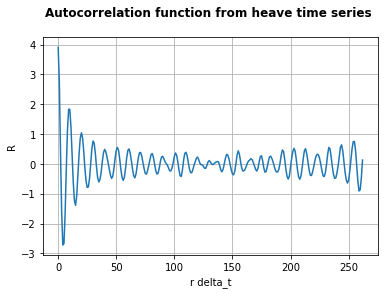

In [25]:
def plotAutocorrelationFunction():
    '''Compute and plot the autocorrelation function'''
    numberOfLags = math.floor(len(detrendedHeaves)/5) # because it must be considerably smaller than len(detrendedHeaves)
    r, R  = autocorrelationFunction(numberOfLags)
    
    plt.plot(r, R)
    plt.title("Autocorrelation function from heave time series \n")
    plt.xlabel("r delta_t")
    plt.ylabel("R")
    plt.show()
    
plotAutocorrelationFunction()

As expected, the finite value of $m$ implies that the surface elevations at large times $Rt > mt$ are uncorrelated.

## 4.2 Power Spectrum from FFT <a name="4.2"></a>

Referencing the development of power spectrum density from previous sections, one can get a a rough estimate of the power spectrum from:

$F(w) = \sum\limits_{t=-\infty}^{\infty} f(t) e^{-iwt}$

$S(w) = |F(w)|^2$

Before applying the FFT to obtain the Power Spectrum, it is important to first detrend heave data (which we already did in part one) to avoid any bias and apply a window function to the heaves before taking the DTFT to avoid the problem of spectral leakage (the spreading of a signal among several frequencies). So we compute and plot the power spectrum in the following cells.

We make the sampling interval 𝑑𝑡dt available for use throughout the report:

In [26]:
# dt is the sampling interval
dt = 0.78

# We assert that the hard coded value in the last cell is vaguely close to the sampling interval
# obtained from the actual sample
assert(np.isclose(times[1] - times[0], dt, atol=0.2))

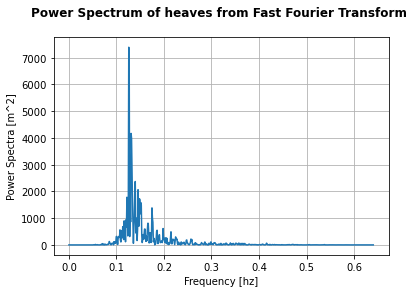

In [27]:
def plotPowerSpectrumFromFFT():
    '''Using Numpy to plot the Power Spectrum of the heaves, 
    assuming heave data is already detrended.
    Also, we window heave values before applying the Discrete Fourier Transform (DFT)'''
    # Apply a Hanning window to avoid spectral leakage
    window = np.hanning(len(detrendedHeaves))*detrendedHeaves

    # Calculate the power spectrum
    powerSpectrum = np.abs(np.fft.rfft(window))**2
    fs = np.fft.rfftfreq(len(window), dt) # frequencies

    # We sort the obtained frequencies and find its indexes
    idx = np.argsort(fs)

    # And plot the Power Spectrum against frequencies in the corret order
    plt.plot(fs[idx], powerSpectrum[idx])
    plt.title("Power Spectrum of heaves from Fast Fourier Transform \n")
    plt.xlabel("Frequency [hz]")
    plt.ylabel("Power Spectra [m^2]")
    plt.show()
    
plotPowerSpectrumFromFFT()

## 4.3 Noise Reduction with Daniell's, Bartlett and Welch’s methods <a name="4.3"></a>

The calculated Power Spectrum is quite sensitive to any noise (unwanted/unexpected modifications that a signal may suffer during capture, storage, transmission, processing, or conversion) in the heaves. It can be proved that the periodogram method will always be a biased estimator, even for large samples and that, with this method, the variance at a given frequency does not decrease as the number of samples used in the computation increases. To mitigate the high variance and reduce noise, some method modifications are applied to the periodogram.

### A) Daniell's Method <a name="4.3A"></a>

### B) Bartlett's Method <a name="4.3B"></a>

For our problem, Bartlett's method approaches the noise problem by implementing the following steps:

1. The number of heaves is split up into N equally spaced segments of length L
2. For each segment, the periodogram method is computed using a DTFT (considering a Power Spectrum Density) and then squaring the result and dividing it by L
3. The average result of the computed periodograms is taken, reducing the variance and thus the noise

We implement Bartlett's Method with Scipy considering a particular case of the Welch method when there is no overlap between segments (see [C section](#4.3C) for more details)

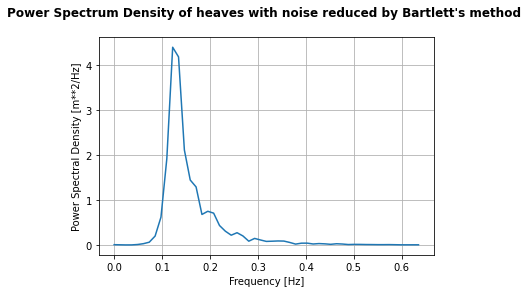

In [28]:
from scipy import signal

def welchSpectrum(noverlap, nperseg):
    '''Calculate Power Spectral Densitites with Welch's method from 
    given number of points to overlap between segments (noverlap) and 
    lenght of each periodogram (nperseg). Returns an array with frequencies
    and PSDs. We are using scipy.signal.welch, more info avaliable on: 
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html'''
    return signal.welch(heaves, 
        detrend="constant", # Detrend each heave by subtracting the heave mean, as we did for time-series
        window="hanning", # Apply a Hanning window before taking the Discrete Fourrier Transform (DFT)
        fs=(1 / dt), # Sample rate
        scaling="density", # Compute the power spectral density
        noverlap=noverlap, # Number of points to overlap between segments
        nperseg=nperseg) # Lenght of each periodogram

def plotBartlettPSD():
    '''Plot the Power Spectrum Density, computed using Bartlett's method'''
    def bartlettSpectrum(): 
        '''If there's no overlap, i.e, noverlap is 0, Welch's method is 
        equivalent to Bartlett’s method '''
        degreesOfFreedom = 25
        numberOfWindows = len(heaves) / (degreesOfFreedom / 2)
        return welchSpectrum(noverlap=0, nperseg=numberOfWindows)
    
    # fsBartlett are frequencies in hertz and PSD power spectral densities in meters squared/hertz
    fsBartlett, PSDBartlett = bartlettSpectrum()
    plt.plot(fsBartlett, PSDBartlett)
    plt.title("Power Spectrum Density of heaves with noise reduced by Bartlett's method \n")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [m**2/Hz]")
    plt.show()
    
plotBartlettPSD()

### C) Welch's Method <a name="4.3C"></a>

The Welch method is an extension of Bartlett's method, being implemented in the following way:

1. The signal (in our case, heaves) is split up into N overlapping segments of length L, overlapped by D points 
    1. If D = L/2, the value we use in our case, the overlap is said to be 50%, which is a reasonable trade off between accurately estimating the signal power, while not over counting any of the data
    2. If D = 0, there's no overlapping - then Welch's method becomes Bartlett's method
2. The overlapping segments are then windowed (functions that allow us to distribute the leakage spectrally) - each individual segment has a window function applied (in our case, we use the Hanning window)
3. For each windowed segment, the periodogram method is computed using a DTFT (considering a Power Spectrum Density) and then squaring the result and dividing it by L
4. The average result of the computed periodograms is taken, reducing the variance and thus the noise

Theoretically, Welch's method better reduces the noise, but gives less frequency resolution than Bartlett method. Using the same Scipy function as before, we implement Welch's method considering the number of degrees of freedom and the impact of this parameter on the length of each segment and hence noise reduction and resolution:

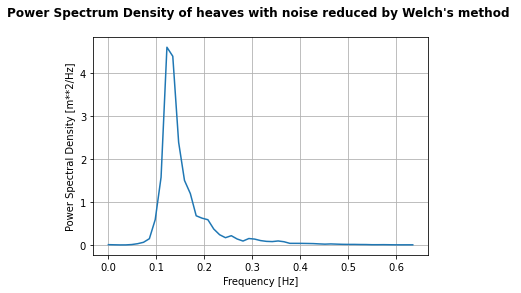

In [29]:
# We compute the Power Spectral Densities using Welch's method
degreesOfFreedom = 25
numberOfWindows = len(heaves) / (degreesOfFreedom / 2)

fsWelch, PSDWelch = welchSpectrum(nperseg=numberOfWindows, noverlap=numberOfWindows//2) 

def plotWelchPSD():
    '''Plot the Power Spectrum Density from computed values'''
    plt.plot(fsWelch, PSDWelch)
    plt.title("Power Spectrum Density of heaves with noise reduced by Welch's method \n")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [m**2/Hz]")    
    plt.show()
    
plotWelchPSD()

Increasing the number of degrees of freedom decreases the length of each segment (nperseg). A large length gives larger output arrays with correspondingly greater frequency resolution, but this comes at the cost of making the power density spectrum more sensitive to noise*, since there is less averaging by Welch's method happening over time. After systematically changing the number of degrees of freedom, it was concluded that 25 is a reasonable compromise between achieving satisfactory frequency resolution and at the same time mitigating noise.

## 4.4 Spectral Moments <a name="4.4"></a>

### A) First Four Spectral Moments <a name="4.4A"></a>

In signal processing analysis, spectral moments stand as a powerful mathematical tool widely used to condense temporal information into a few scalar quantities that can describe the signal distribution. The first four statistical moments can be combined to fully characterize a signal by evaluating its mean, standard deviation, skewness, and kurtosis. For a one-sided (positive frequency) power spectral density, the n-th spectral moment is defined as:

$ m_n = \int\limits_{0}^{\infty} f^n S(f) df $

We can then use numerical methods to calculate each moment: 

In [30]:
from scipy import integrate

# We use Simpson's method to perform the integration. See more on:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.simpson.html

m0 = integrate.simps(PSDWelch, fsWelch)
m1 = integrate.simps(fsWelch*PSDWelch, fsWelch)
m2 = integrate.simps((fsWelch**2)*PSDWelch, fsWelch)
m3 = integrate.simps((fsWelch**3)*PSDWelch, fsWelch)

spectralMoments = [m0, m1, m2, m3]

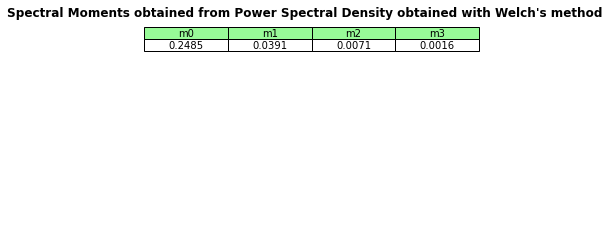

In [31]:
def plotSpectralMomentsTable(spectralMoments):
    '''Receives a list of spectral momentsand plot a table with them'''
    colLabels = ["m0", "m1", "m2", "m3"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(moment, 4) for moment in spectralMoments]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.axis("off")
    plt.title("Spectral Moments obtained from Power Spectral Density obtained with Welch's method") 
    plt.show()


plotSpectralMomentsTable(spectralMoments)

### B) Spectral Bandwidth Coefficient <a name="4.4B"></a>

The spectral bandwidth coefficient gives a measure of the spreading of energy over wave frequencies and can be used for a broad range of purposes, from evaluating wave energy converter's efficiency to predicting wave groupiness. We can calculate this coefficient with the formula below:

$ s^2 = \frac {m_0 m_2 - m_1^2}{m_1^2}$

Which we can calculate in code as:

In [32]:
spectralBandwidthCoeff = np.sqrt((m0 * m2 - m1**2) / m1**2)

And show in a table:

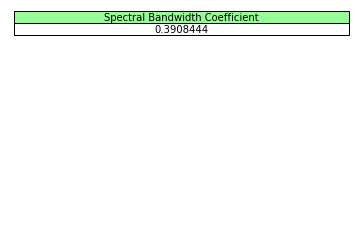

In [33]:
def plotSpectralBandwidthCoeffTable(coeff):
    '''Receives the spectral bandwidth coeff and plot a table with it'''
    colLabels = ["Spectral Bandwidth Coefficient"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(coeff, 7)]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.axis("off")
    plt.show()

plotSpectralBandwidthCoeffTable(spectralBandwidthCoeff)

### C) Peak Period and Significant Wave Height <a name="4.4C"></a>

To calculate the peak period, we just find the frequency with maximum corresponding power spectrum density ($F_p$) and apply the formula $T_p = \frac {1}{F_p}$:


In [34]:
peakSpecIndex = np.argmax(PSDWelch) # Peak of the Power Spectral Density

Fp = fsWelch[peakSpecIndex] # Corresponding peak frequency in hertz
Tp = 1 / Fp # Peak period in seconds

And the significant wave height is related to the zeroth spectral moment according to the following formula:

$ H_s = 4 \sqrt{m_0}$

Which we can calculate as:

In [35]:
Hs = 4 * np.sqrt(m0) # Significant Height in meters

And then show the peak period and the significant wave height in a table:

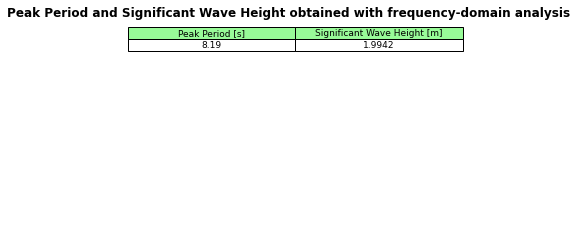

In [36]:
def plotPeakPeriodAndSignificantHeightTable(peakPeriod, significantHeight):
    '''Receives the peak period and significant height and plot a table with them'''
    colLabels = ["Peak Period [s]", "Significant Wave Height [m]"]
    plt.table(
        colLabels = colLabels,
        cellText = [[round(value, 4) for value in [peakPeriod, significantHeight]]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="upper left")
    
    plt.title("Peak Period and Significant Wave Height obtained with frequency-domain analysis")
    plt.axis("off")
    plt.show()

plotPeakPeriodAndSignificantHeightTable(Tp, Hs)

### D) Significant Wave Height comparison with time domain analysis <a name="4.4D"></a>

To evaluate if the values are compatible, we just calculate their percentual discrepancy and show both significant heights (obtained by time and frequency domain analysis) in a table:

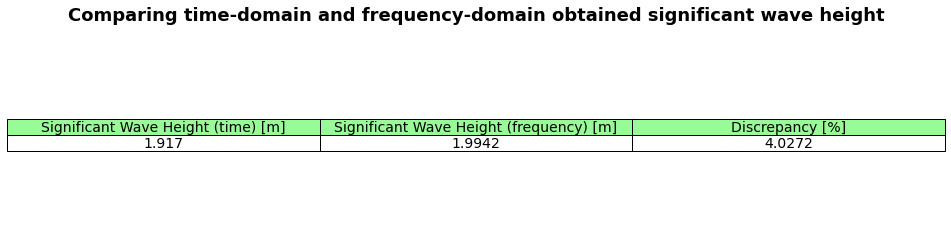

In [37]:
def plotSignificantHeightComparisonTable(HsTime, HsFrequency, percentualDiscrepancy):
    '''Receives the significant wave height obtained in time-domain and in
    frequency domain and plots a table comparing them'''
    colLabels = ["Significant Wave Height (time) [m]", "Significant Wave Height (frequency) [m]", "Discrepancy [%]"]
    table = plt.table(
        colLabels = colLabels,
        cellText = [[round(val, 4) for val in [HsTime, HsFrequency, percentualDiscrepancy]]],
        colColours =["palegreen"] * len(colLabels), 
        cellLoc ="center",  
        loc ="center")
    table.auto_set_font_size(False)
    table.scale(2.8, 1.3)
    table.set_fontsize(14)
    
    plt.title("Comparing time-domain and frequency-domain obtained significant wave height", fontsize=18)
    plt.axis("off")
    plt.show()

HsTimeDomain = downCrossingSignificantStats["significantHeight"] # We consider the down-crossing method to be more accurate
percentualDiscrepancy = 100*np.abs(HsTimeDomain - Hs) / HsTimeDomain

plotSignificantHeightComparisonTable(HsTimeDomain, Hs, percentualDiscrepancy)

## 4.5 Comparing obtained Power Spectrum with Theoretical Spectral Model

The selected model was the JONSWAP spectrum. This model is a variation of the model proposed by Pierson and Moskowitz, which relied on the assumption that if the wind blew steadily for a long time over a large area, the waves would come into equilibrium with the wind. The Joint North Sea Wave Observation Project (JONSWAP) nevertheless found that the wave spectrum is never fully developed in practice, it is always developing through non-linear, wave-to-wave interactions even for very long times and distances. To incorporate this reality of non-equilibrium into the model, the empirical "extra peak enhancement" factor was added, in a way that the JONSWAP model is just the Pierson-Moskowitz spectrum multiplied by this factor. The formula for the JONSWAP power spectrum density is given by:

$ S(f) =  \beta_j H_s^2 Tp^{-4} f^{-5} e^{-1.25 ({f T_p})^{-4}} \gamma^{e^\frac{(-f T_p)^{2}}{2 \sigma^2}} $

Where:

$ \beta_j = \frac {0.0624(1.094 - 0.01915.ln(\gamma))} {0.23 + 0.0336\gamma - 0.185(1.9 + \gamma)^{-1}} $

And:

$ \sigma = 0.07 $ if $f <= f_p$ <br />
$ \sigma = 0.09 $ if $f > f_p$


We can then calculate the expcted power spectrum densities predicted by the JONSWAP method with the following program:

In [38]:
def jonswapSpectrum(fs, Hs, Tp):
    D = 0.036 - 0.0056*Tp/np.sqrt(Hs)
    gama = np.exp(3.484*(1 - 0.1975*D*Tp**4/(Hs**2)))
    beta = (0.0624*(1.094 - 0.01915*np.log(gama))) / \
        (0.23 + 0.0336*gama - 0.185*(1.9 + gama)**(-1))
    fp = 1/Tp
    def sigma(f): return 0.07 if f <= fp else 0.09

    def S(f):
        return beta*Hs**2*Tp**(-4)*f**(-5)*np.exp(-1.25*(Tp*f)**(-4))*gama**np.exp(-((Tp*f-1)**2)/2*sigma(f)**2)

    powerSpectralDensities = [S(f) for f in fs]
    return powerSpectralDensities

And then comparing the obtained spectrum with what was obtained with Welch's method:

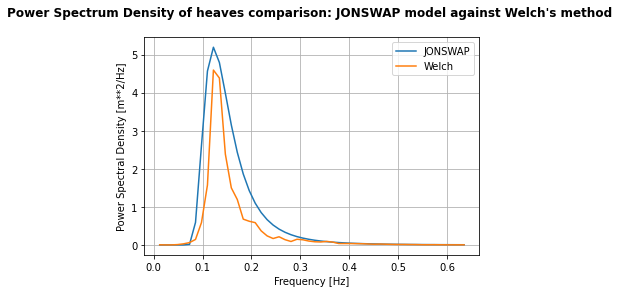

In [39]:
def plotJonsawpSpectrumComparison():
    # Remove frequencies equivalent to 0 and corresponding PSD's
    # because we divide by frequency in JONSWAP spectrum
    fsWithoutZeros, PSDWelchWithoutZeroFs = [], []
    for i, f in enumerate(fsWelch):
        if f != 0:
            fsWithoutZeros.append(f)
            PSDWelchWithoutZeroFs.append(PSDWelch[i])
                
    PSDJonswap = jonswapSpectrum(fsWithoutZeros, Hs=Hs*1, Tp=Tp)
    plt.plot(fsWithoutZeros, PSDJonswap, label="JONSWAP")
    plt.plot(fsWithoutZeros, PSDWelchWithoutZeroFs, label="Welch")
    plt.title("Power Spectrum Density of heaves comparison: JONSWAP model against Welch's method \n")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Power Spectral Density [m**2/Hz]")
    plt.legend()
    plt.show()
    
    
plotJonsawpSpectrumComparison()

From where we can see that there is a satisfactory consistency between the PSD obtained from the JONSWAP model and from Welch's method. The latter, however, seems to almost always have smaller PSDs, especially near peak frequency values.

# 5. Webgraphy <a name="5"></a>


1) https://www.usna.edu/NAOE/_files/documents/Courses/EN330/Rayleigh-Probability-Distribution-Applied-to-Random-Wave-Heights.pdf

2) https://www.usna.edu/NAOE/_files/documents/Courses/EN330/Random-Wave-Analysis.pdf

3) http://www.iopan.gda.pl/oceanologia/OC_40/OC40_3-4_Cieslikiewicz.pdf

4) https://upcommons.upc.edu/bitstream/handle/2099.1/6034/06.pdf?sequence=7

5) http://www.alekslabuda.com/sites/default/files/publications/[2016-03]%20Daniell%20method%20for%20PSD%20estimation%20in%20AFM.pdf

6) https://www.maths.lu.se/fileadmin/maths/personal_staff/Andreas_Jakobsson/StoicaM05.pdf

7) https://see.stanford.edu/materials/lsoftaee261/book-fall-07.pdf

8) https://www.alpharithms.com/autocorrelation-time-series-python-432909/

9) https://stackoverflow.com/questions/33973717/computing-a-power-spectrum

10) https://wikiwaves.org/Ocean-Wave_Spectra

11) https://fenix.tecnico.ulisboa.pt/downloadFile/845043405556530/MSW9%20-%20Modelling%20of%20Waves%20as%20a%20Random%20Ocean%20Process.pdf

12) http://neumeier.perso.ch/matlab/waves.html

13) https://paginas.fe.up.pt/~m2d/Proceedings_M2D2017/data/papers/6893.pdf

14) https://www.researchgate.net/publication/224166123_Numerical_Modeling_for_an_In_Situ_Single-Point-Mooring_Cage_System